# Clasificador de flores

Bienvenidos. En este ejercicio haremos un clasificador para flores. Usaremos el siguiente dataset: http://www.robots.ox.ac.uk/~vgg/data/flowers/, que contiene 102 categorías y 8192 imágenes de flores de alta calidad. En un momento te diré cómo descargar el dataset ya editado por mi para hacerlo más fácil de manejar.

Al final lograremos llegar a 99.21% de accuracy, aún cuando tenemos 102 tipos de flores diferentes. Esto es muy impresionante, sobre todo considerando que en [este paper](https://www.robots.ox.ac.uk/~vgg/research/flowers_demo/docs/Chai11.pdf) reportan 81% de accuracy, y que en [este otro](http://www.cs.huji.ac.il/~daphna/IsraeliFlowers/flower_classification.html) reportan 93.8%! 

Es decir, lo haremos **7.7 veces mejor** que ese último!! (0.8% vs 6.2% de error)

Vamos a incluir las bibliotecas que usaremos, que son [fast.ai](https://www.fast.ai/) y [pytorch](https://pytorch.org).

In [1]:
import fastai.vision.all as fv

from pathlib import Path

### ¿Cómo son nuestros datos?

Siempre antes de empezar a trabajar en algún problema, hay que entender bien qué problema queremos resolver. En este caso, simplemente queremos clasificar flores en base a sus imágenes.

Después, hay que entender los [datos](https://my.pcloud.com/publink/show?code=XZiwtw7Z15TY80dPm4b3KwmNcf1ChfphgM5y). En este caso, de las flores, pensemos que ya los descargamos, descomprimimos y están en un carpeta llamada "flowers".

In [2]:
!ls flowers/

models/  tmp/  train/  valid/


Posiblemente tú no tendrás tmp ni models aún. Eso se crean solitos después.

In [3]:
!ls flowers/train

alpine-sea-holly/    fire-lily/                  peruvian-lily/
anthurium/           foxglove/                   petunia/
artichoke/           frangipani/                 pincushion-flower/
azalea/              fritillary/                 pink-primrose/
ball-moss/           garden-phlox/               pink-yellow-dahlia/
balloon-flower/      gaura/                      poinsettia/
barbeton-daisy/      gazania/                    primula/
bearded-iris/        geranium/                   prince-of-wales-feathers/
bee-balm/            giant-white-arum-lily/      purple-coneflower/
bird-of-paradise/    globe-flower/               red-ginger/
bishop-of-llandaff/  globe-thistle/              rose/
blackberry-lily/     grape-hyacinth/             ruby-lipped-cattleya/
black-eyed-susan/    great-masterwort/           siam-tulip/
blanket-flower/      hard-leaved-pocket-orchid/  silverbush/
bolero-deep-blue/    hibiscus/                   snapdragon/
bougainvillea/       hippeastrum/            

Ya entendimos cómo están las imágenes y su clasificación. (Nota: el archivo original que bajas de oxford no estaba bien acomodado así, estaba en un csv y así, medio feito, yo lo convertí.)

In [4]:
flowers = Path("flowers/")

In [5]:
(flowers/"train").ls()

(#102) [Path('flowers/train/stemless-gentian'),Path('flowers/train/rose'),Path('flowers/train/cautleya-spicata'),Path('flowers/train/monkshood'),Path('flowers/train/globe-flower'),Path('flowers/train/tiger-lily'),Path('flowers/train/peruvian-lily'),Path('flowers/train/bishop-of-llandaff'),Path('flowers/train/azalea'),Path('flowers/train/yellow-iris')...]

In [6]:
files = fv.get_image_files("flowers"); files

(#8188) [Path('flowers/train/stemless-gentian/image_05227.jpg'),Path('flowers/train/stemless-gentian/image_05216.jpg'),Path('flowers/train/stemless-gentian/image_05253.jpg'),Path('flowers/train/stemless-gentian/image_05269.jpg'),Path('flowers/train/stemless-gentian/image_05214.jpg'),Path('flowers/train/stemless-gentian/image_05273.jpg'),Path('flowers/train/stemless-gentian/image_05248.jpg'),Path('flowers/train/stemless-gentian/image_05261.jpg'),Path('flowers/train/stemless-gentian/image_05243.jpg'),Path('flowers/train/stemless-gentian/image_05263.jpg')...]

In [7]:
fv.doc(fv.get_image_files)

get_image_files [source] get_image_files ( path , recurse = True , folders = None ) 
 
 Get image files in path recursively, only in folders , if specified. 
 Show in docs

## Abriendo los datos en fastai

Dado que nuestros datos están bien acomodados en folders, vamos a crear un "ImageDataBunch" a partir del folder.

Usaremos "data augmentation" (más sobre esto después), estableciendo transformadas.

**Nota:** bs = batch size. Es decir, cuántas imágenes pasa al mismo tiempo a la red neuronal. Mi tarjeta de video tiene 11GB de memoria, por es puedo poner un número relativamente grande. Si obtienes "CUDA error: out of memory", disminuye la batch size!

Podríamos también cargar los datos "a mano", como se muestra en las siguientes celdas. Para más información, ver el [datablock-api](https://docs.fast.ai/data_block.html)

In [8]:
fv.doc(fv.aug_transforms)

aug_transforms [source] aug_transforms ( mult = 1.0 , do_flip = True , flip_vert = False , max_rotate = 10.0 , min_zoom = 1.0 , max_zoom = 1.1 , max_lighting = 0.2 , max_warp = 0.2 , p_affine = 0.75 , p_lighting = 0.75 , xtra_tfms = None , size = None , mode = 'bilinear' , pad_mode = 'reflection' , align_corners = True , batch = False , min_scale = 1.0 ) 
 
 Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms. 
 Show in docs

In [9]:
def load_data(folder, img_size, batch_size):
    
    tfms = fv.aug_transforms(flip_vert=True, max_rotate=360, max_lighting=0.3,max_zoom=1.2,max_warp=0.2)
    
    data = fv.DataBlock(
                        blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(folder,bs=batch_size)

In [10]:
data = load_data(flowers, img_size=224, batch_size=128)

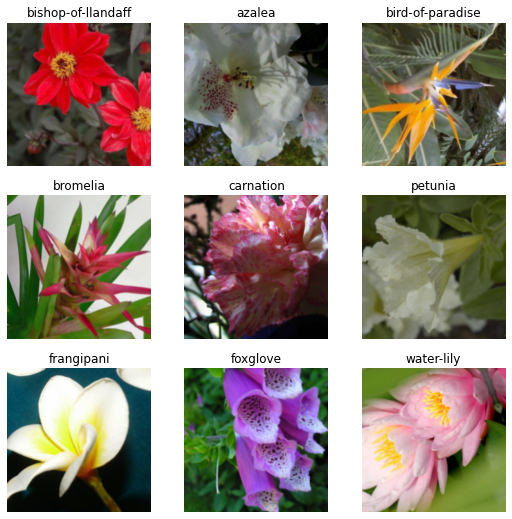

In [11]:
data.show_batch()

In [12]:
x,y = data.one_batch()

In [13]:
x.shape

torch.Size([128, 3, 224, 224])

In [14]:
y.shape

torch.Size([128])

## Entrenamiento

Ahora crearemos un objeto de tipo "Learner" (más sobre esto después), con arquitectura de "resnet18". Qué es esto? No te preocupes!

In [19]:
learner = fv.cnn_learner(data, fv.resnet34, metrics=fv.accuracy, opt_func=fv.ranger)

### Entrenamos *sólo de las últimas capas*

Vamos a usar la función "fit_one_cycle", que es una manera muy rápida de entrenar (discutiremos por qué después). ¿Qué learning rate usamos? Pues vamos a averiguar!

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.033113110810518265)

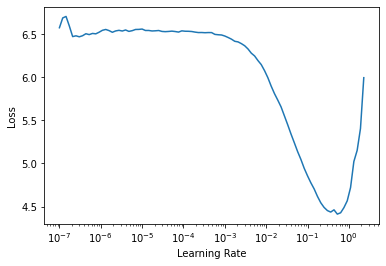

In [16]:
learner.lr_find()

In [20]:
learner.fit_one_cycle(4,
                      lr_max=2e-2,
                      div=0.8,
                      final_div=1000.,
                      pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,1.574042,0.311045,0.901186,00:15
1,0.786201,0.281097,0.913043,00:15
2,0.586574,0.226736,0.926877,00:15
3,0.452227,0.171449,0.952569,00:15


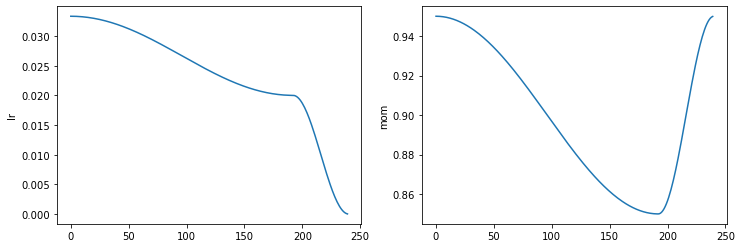

In [21]:
learner.recorder.plot_sched()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.5848931980144698e-06)

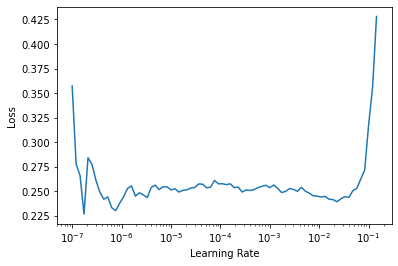

In [22]:
learner.lr_find()

In [23]:
learner.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.260627,0.155840,0.952569,00:15
1,0.228997,0.140703,0.960474,00:15
2,0.201686,0.138311,0.958498,00:15


In [24]:
learner.save('stage1')

Path('models/stage1.pth')

In [25]:
learner.load('stage1');

### Entrenamiento de TODAS las capas

En realidad **no hemos estado entrenando a toda la red neuronal!!** Sólo entrenamos las últimas dos capas, y las demás estaban **pre-entrenadas en imagenet**. Por defecto, si pides una arquitectura pre-hecha, vienen "congeladas" las primeras capas. Vamos a entrenar con cuidado toda la red.

In [29]:
learner.unfreeze() # ahora hay que tener cuidado!

SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=1.5848931980144698e-06)

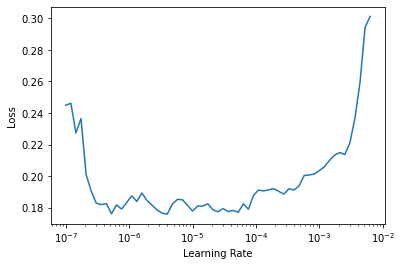

In [30]:
learner.lr_find()

In [ ]:
learner.summary()

Vamos a entrenar toda la red, pero vamos a modificar las primeras capas **menos que las últimas**. Para entender por qué, veamos este paper: [Visualizing and Understading ...](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)

In [31]:
learner.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.246831,0.213609,0.934783,00:20
1,0.415019,0.377610,0.901186,00:20
2,0.300824,0.145093,0.952569,00:20
3,0.180552,0.111658,0.964427,00:20
4,0.115807,0.093391,0.972332,00:20


In [33]:
learner.save('stage2')

Path('models/stage2.pth')

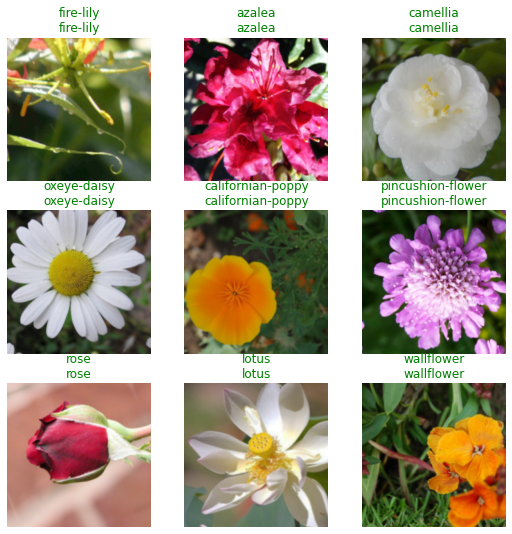

In [41]:
learner.show_results(ds_idx=3,dl=data.train,shuffle=True)

# Interpretando los resultados

Vamos a revisar los resultados que tenemos

In [46]:
interp = fv.ClassificationInterpretation.from_learner(learner)

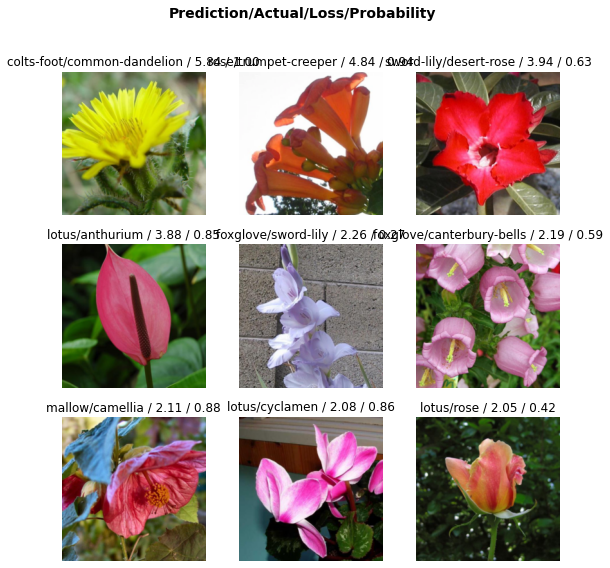

In [48]:
interp.plot_top_losses(9)

Las dos que predecimos mallow pero deberíamos predecir camellia... están de hecho mal clasificadas en el validation set!

Esto es algo muy común, los datasets no son perfectos. Y hacer este tipo de cosas nos da herramientas para encontrar estos errores.

In [53]:
fv.CategoryBlock??

Signature: fv.CategoryBlock(vocab=None, sort=True, add_na=False)
Source:   
def CategoryBlock(vocab=None, sort=True, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))
File:      ~/anaconda3/envs/fastai2/lib/python3.8/site-packages/fastai/data/block.py
Type:      function


In [54]:
fv.TransformBlock??

Init signature:
fv.TransformBlock(
    type_tfms=None,
    item_tfms=None,
    batch_tfms=None,
    dl_type=None,
    dls_kwargs=None,
)
Source:        
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
File:           ~/anaconda3/envs/fastai2/lib/python3.8/site-packages/fastai/data/block.py
Type:           type
Subclasses:     


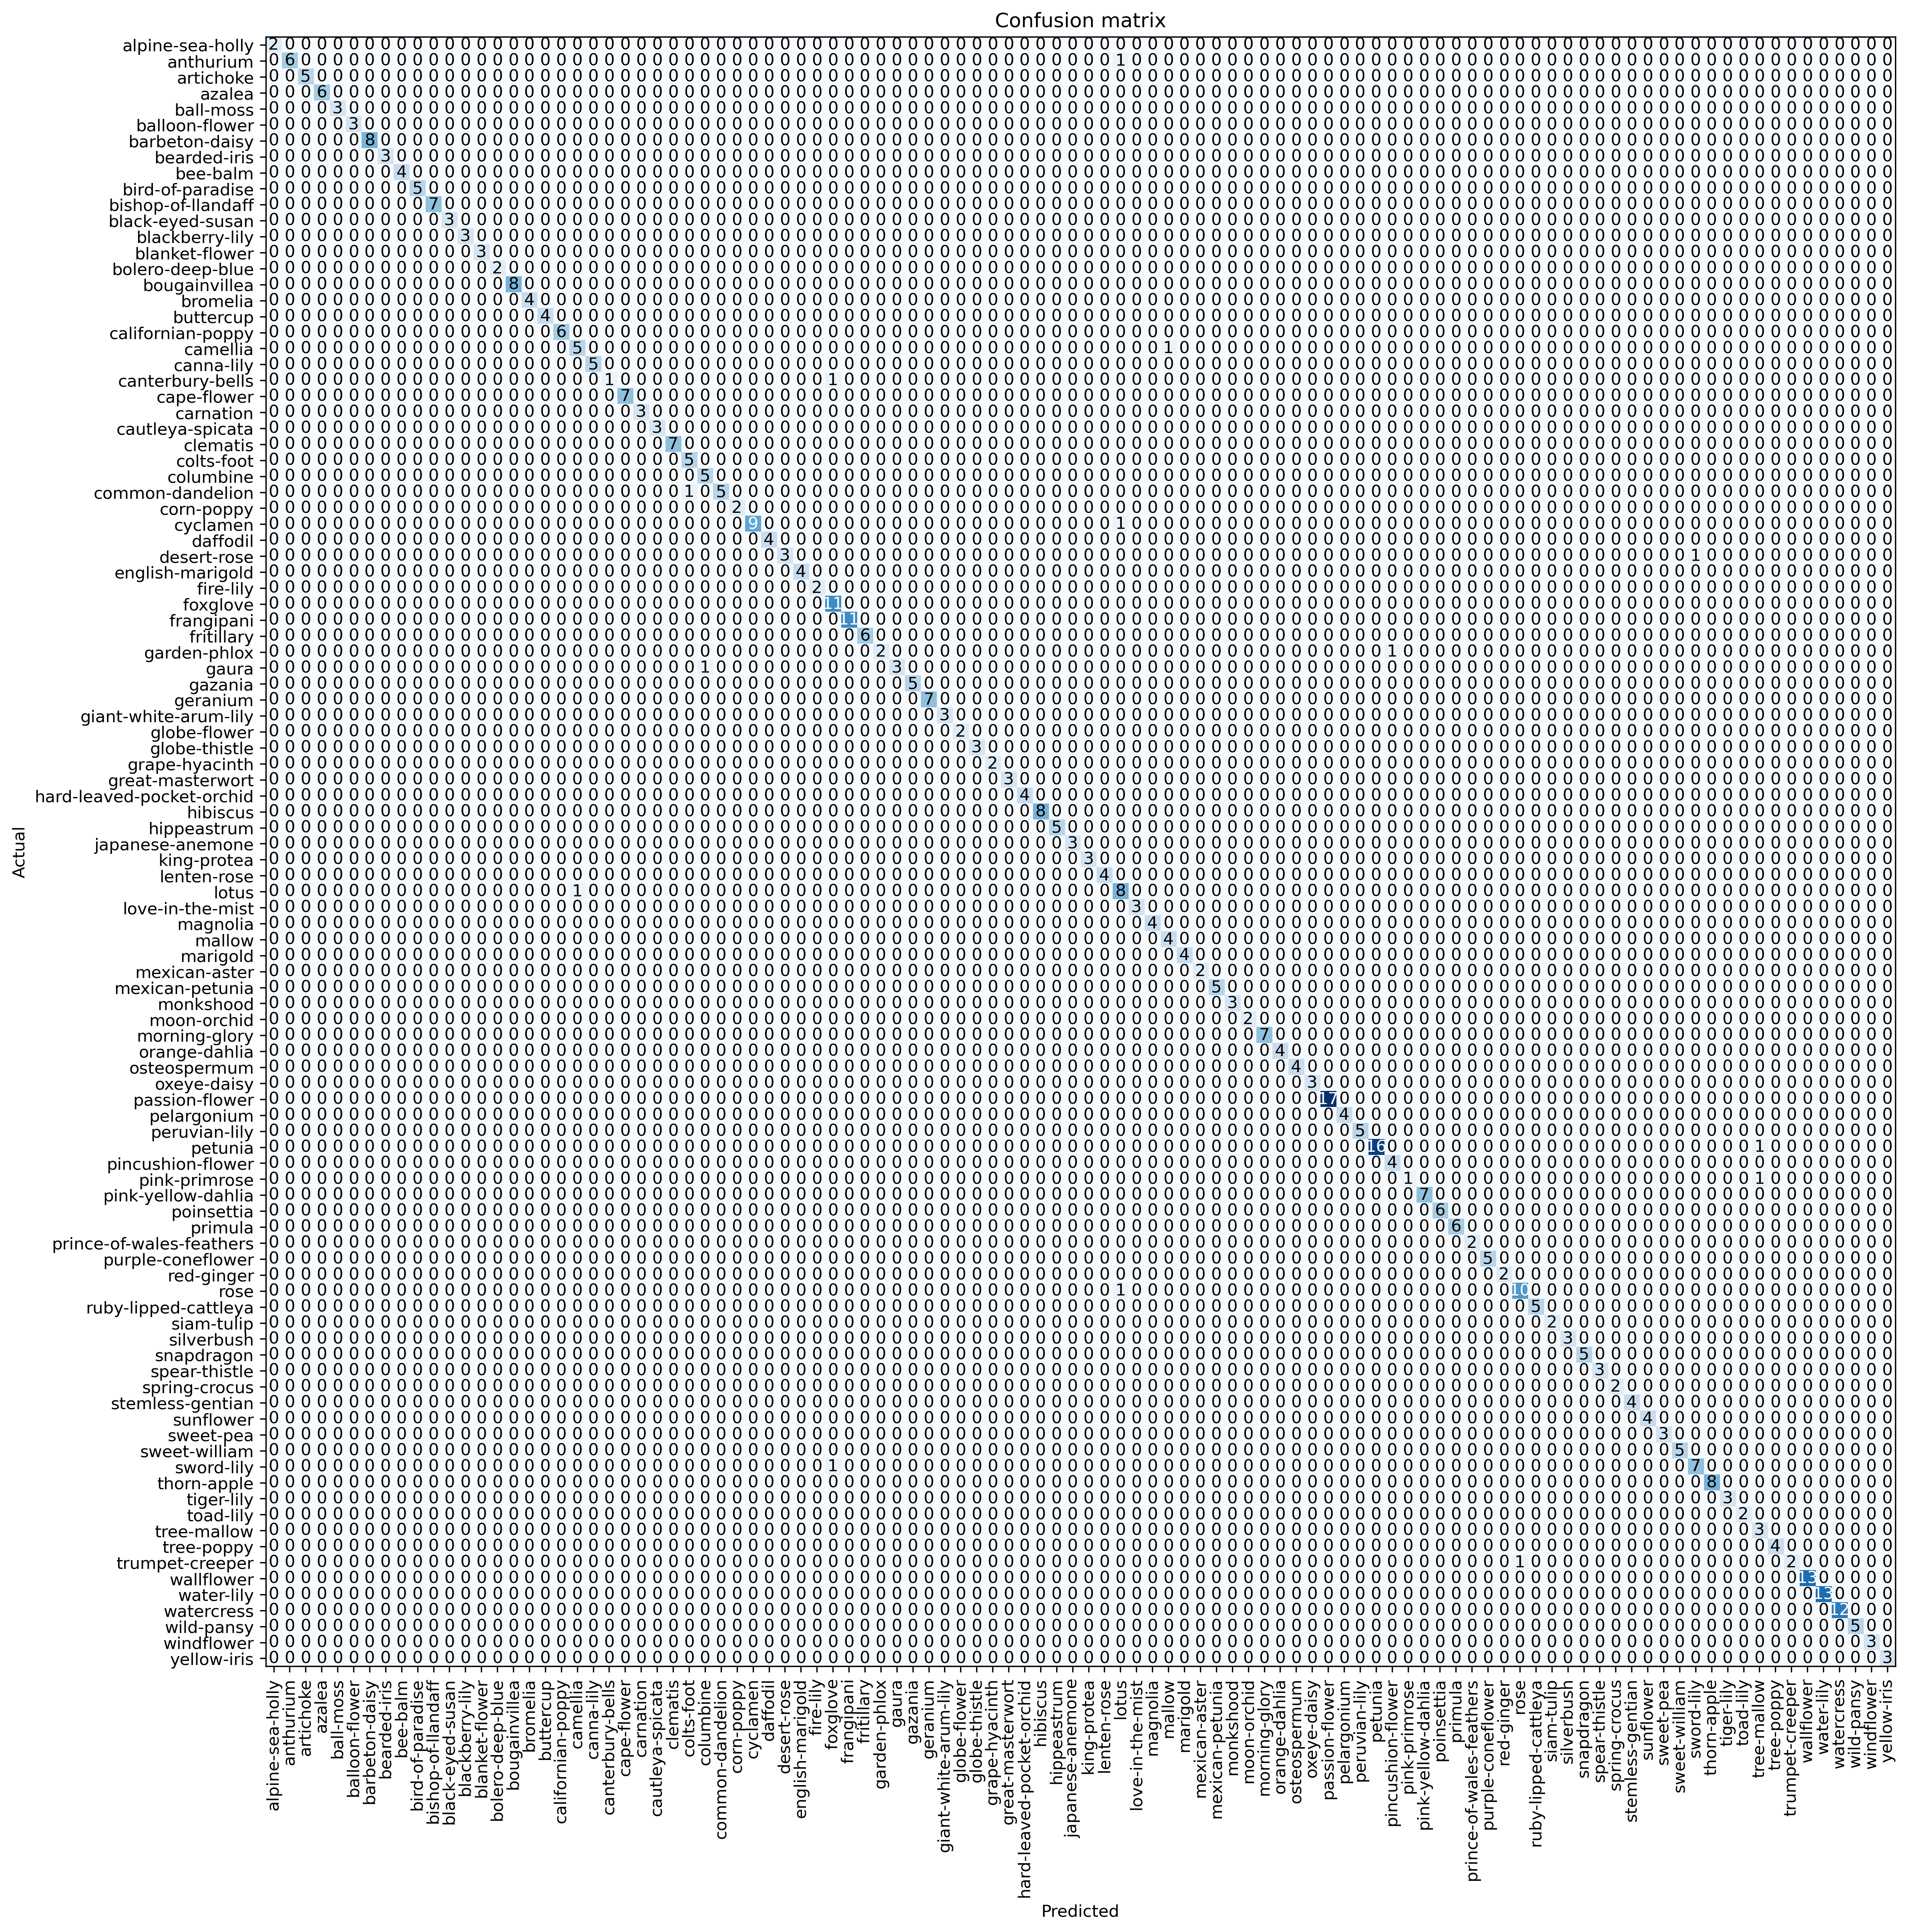

In [49]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=300)

In [50]:
interp.most_confused(1)

[('anthurium', 'lotus', 1),
 ('camellia', 'mallow', 1),
 ('canterbury-bells', 'foxglove', 1),
 ('common-dandelion', 'colts-foot', 1),
 ('cyclamen', 'lotus', 1),
 ('desert-rose', 'sword-lily', 1),
 ('garden-phlox', 'pincushion-flower', 1),
 ('gaura', 'columbine', 1),
 ('lotus', 'camellia', 1),
 ('petunia', 'tree-mallow', 1),
 ('pink-primrose', 'tree-mallow', 1),
 ('rose', 'lotus', 1),
 ('sword-lily', 'foxglove', 1),
 ('trumpet-creeper', 'rose', 1)]